In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tqdm

     |████████████████████████████████| 2.3MB 29.3MB/s 
     |████████████████████████████████| 3.3MB 43.2MB/s 
     |████████████████████████████████| 901kB 37.1MB/s 


In [3]:
import torch
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AdamW, get_linear_schedule_with_warmup,RobertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import time
import datetime
import random
from tqdm import tqdm

In [4]:
trainNews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OutputFiles/TrainNews.csv')

In [5]:
trainNews

,label,text,title
0,1,the head of a conservative republican faction ...,as u s budget fight looms republicans flip the...
1,1,transgender people will be allowed for the fir...,u s military to accept transgender recruits on...
2,1,the special counsel investigation of links bet...,senior u s republican senator let mr mueller d...
3,1,trump campaign adviser george papadopoulos tol...,fbi russia probe helped by australian diplomat...
4,1,president donald trump called on the u s posta...,trump wants postal service to charge much more...
...,...,...,...
51192,1,the state department told the republican natio...,state department says it can t find emails fro...
51193,0,the p in pbs should stand for plutocratic or p...,the p in pbs should stand for plutocratic or p...
51194,0,anti trump protesters are tools of the oligarc...,anti trump protesters are tools of the oligarc...
51195,1,addis ababa ethiopia president obama convened ...,in ethiopia obama seeks progress on peace secu...


In [6]:
trainNews = trainNews[trainNews.text.str.len() >= 5]

trainNews['fullNewsText'] = trainNews['title'] + ". " + trainNews['text']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
trainNews

,label,text,title,fullNewsText
0,1,the head of a conservative republican faction ...,as u s budget fight looms republicans flip the...,as u s budget fight looms republicans flip the...
1,1,transgender people will be allowed for the fir...,u s military to accept transgender recruits on...,u s military to accept transgender recruits on...
2,1,the special counsel investigation of links bet...,senior u s republican senator let mr mueller d...,senior u s republican senator let mr mueller d...
3,1,trump campaign adviser george papadopoulos tol...,fbi russia probe helped by australian diplomat...,fbi russia probe helped by australian diplomat...
4,1,president donald trump called on the u s posta...,trump wants postal service to charge much more...,trump wants postal service to charge much more...
...,...,...,...,...
51192,1,the state department told the republican natio...,state department says it can t find emails fro...,state department says it can t find emails fro...
51193,0,the p in pbs should stand for plutocratic or p...,the p in pbs should stand for plutocratic or p...,the p in pbs should stand for plutocratic or p...
51194,0,anti trump protesters are tools of the oligarc...,anti trump protesters are tools of the oligarc...,anti trump protesters are tools of the oligarc...
51195,1,addis ababa ethiopia president obama convened ...,in ethiopia obama seeks progress on peace secu...,in ethiopia obama seeks progress on peace secu...


In [8]:
trainNews = trainNews.drop(['title', 'text'], axis=1)

In [9]:
trainNews.to_csv("/content/drive/MyDrive/Colab Notebooks/OutputFiles/FinalTrainNews.csv", index=False)

In [10]:
trainNews = trainNews.dropna()

In [11]:
fullNewsSentences = trainNews["fullNewsText"].values
targetLabels = trainNews["label"].values

In [12]:
robertaModel = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                                    num_labels = 2,
                                                                    output_attentions = False,
                                                                    output_hidden_states = False)
robertaTokenizer = RobertaTokenizer.from_pretrained("roberta-base")

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    robertaModel.cuda()
else:
    device = torch.device('cpu')
print(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi


cuda:0


In [13]:
def convertToTensor(newsSentences,labels):
    idsRoberta = []
    robertaMasks = []
    for news in newsSentences:
        robertaEncoded = robertaTokenizer.encode_plus(news,add_special_tokens = True,
                                                      max_length = 256,
                                                      truncation=True,
                                                      padding='max_length',
                                                      return_attention_mask = True,
                                                      return_tensors = 'pt')
        idsRoberta.append(robertaEncoded['input_ids'])
        robertaMasks.append(robertaEncoded['attention_mask'])
    idsRoberta = torch.cat(idsRoberta, dim=0)
    robertaMasks = torch.cat(robertaMasks, dim=0)
    labels = torch.tensor(labels)
    tensonDataset = TensorDataset(idsRoberta, robertaMasks, labels)
    return tensonDataset

In [14]:
torch.manual_seed(0)
fullTensor = convertToTensor(fullNewsSentences,targetLabels)

In [15]:
trainSetSize = int(0.95*len(fullTensor))
validSetSize = len(fullTensor) - trainSetSize

In [16]:
trainTensor, validTensor = random_split(fullTensor, [trainSetSize, validSetSize])

In [17]:
batchSize = 16
trainDataloader = DataLoader(trainTensor,sampler = RandomSampler(trainTensor),
                                      batch_size = batchSize)
validationDataloader = DataLoader(validTensor,sampler = SequentialSampler(validTensor)
                                  ,batch_size = batchSize)

In [18]:
optimizer = AdamW(robertaModel.parameters(),lr = 5e-5,eps = 1e-8)

In [19]:
epochs = 4
totalSteps = len(trainDataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                                    num_training_steps = totalSteps)

In [20]:
def getAccuracy(preds, labels):
    flatPredictions = np.argmax(preds, axis=1).flatten()
    flatLabels = labels.flatten()
    return np.sum(flatPredictions == flatLabels) / len(flatLabels)

In [22]:
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
trainingData = []

for epochNumber in range(0, epochs):
    print("\n\nTraining epoch "+str(epochNumber+1)+" started.\n\n\n")
    traininglossTotal = 0
    robertaModel.train()
    pbar = tqdm(total=len(trainDataloader), position=0, leave=True)
    for step, batch in enumerate(trainDataloader):
        pbar.update(1)
        robertaModel.zero_grad()        
        trainData = robertaModel(batch[0].to(device),attention_mask=batch[1].to(device),labels=batch[2].to(device))
        loss = trainData["loss"]
        traininglossTotal += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(robertaModel.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avgTrainLoss = traininglossTotal / len(trainDataloader)
    pbar.close()
    print("\n\n\tTraining loss: "+str(round((avgTrainLoss),2)))
    
    #changing to Validation mode
    print("\n\n\nValidation epoch "+str(epochNumber+1)+" started.")
    robertaModel.eval()
    validationAccuracy = 0
    validationLossTotal = 0
    pbar = tqdm(total=len(validationDataloader), position=0, leave=True)
    for step, batch in enumerate(validationDataloader):
        pbar.update(1)
        label = batch[2].to(device)
        with torch.no_grad():        
          val = robertaModel(batch[0].to(device),attention_mask=batch[1].to(device),labels=batch[2].to(device))
          loss = val["loss"]
          logits = val["logits"]
        validationLossTotal += loss.item()
        logits = logits.detach().cpu().numpy()
        labelsIds = label.to('cpu').numpy()
        validationAccuracy += getAccuracy(logits, labelsIds)
    validationAccuracyAvg = validationAccuracy / len(validationDataloader)
    pbar.close()
    print("\n\n\tAccuracy: "+str(round((validationAccuracyAvg),2)))
    validateLossAvg = validationLossTotal / len(validationDataloader)
    trainingData.append(
        {
            'epoch': epochNumber + 1,
            'TrainingLoss': avgTrainLoss,
            'ValidationLoss': validateLossAvg,
            'ValidationAccuracy': validationAccuracyAvg
        }
    )
    print("\tValidation Loss: "+str(round((validateLossAvg),2)))

  0%|          | 0/3003 [00:00<?, ?it/s]



Training epoch 1 started.





  0%|          | 0/159 [00:00<?, ?it/s]



	Training loss: 0.08



Validation epoch 1 started.


  0%|          | 0/3003 [00:00<?, ?it/s]



	Accuracy: 0.98
	Validation Loss: 8.72


Training epoch 2 started.





  0%|          | 0/159 [00:00<?, ?it/s]



	Training loss: 0.05



Validation epoch 2 started.


  0%|          | 0/3003 [00:00<?, ?it/s]



	Accuracy: 0.98
	Validation Loss: 10.41


Training epoch 3 started.





  0%|          | 0/159 [00:00<?, ?it/s]



	Training loss: 0.03



Validation epoch 3 started.


  0%|          | 0/3003 [00:00<?, ?it/s]



	Accuracy: 0.99
	Validation Loss: 6.31


Training epoch 4 started.





  0%|          | 0/159 [00:00<?, ?it/s]



	Training loss: 0.02



Validation epoch 4 started.


100%|██████████| 159/159 [00:41<00:00,  3.82it/s]



	Accuracy: 0.99
	Validation Loss: 6.31


In [23]:
torch.save(robertaModel.state_dict(), "/content/drive/MyDrive/Colab Notebooks/OutputFiles/trainedRobertamodel.pkl")

In [24]:
trainingData

[{'TrainingLoss': 0.07852579245879245,
  'ValidationAccuracy': 0.9799528301886793,
  'ValidationLoss': 0.0871973520015958,
  'epoch': 1},
 {'TrainingLoss': 0.05293638268503498,
  'ValidationAccuracy': 0.9811320754716981,
  'ValidationLoss': 0.10409464180885386,
  'epoch': 2},
 {'TrainingLoss': 0.03162472291124313,
  'ValidationAccuracy': 0.985062893081761,
  'ValidationLoss': 0.0630839522862104,
  'epoch': 3},
 {'TrainingLoss': 0.01791213083277803,
  'ValidationAccuracy': 0.985062893081761,
  'ValidationLoss': 0.0630839522862104,
  'epoch': 4}]

In [29]:
from sklearn.metrics import confusion_matrix
robertaModel.eval()
pbar = tqdm(total=len(validationDataloader), position=0, leave=True)
result = [[0,0],[0,0]]
for step, batch in enumerate(validationDataloader):
    pbar.update(1)
    label = batch[2].to(device)
    with torch.no_grad():        
      val = robertaModel(batch[0].to(device),attention_mask=batch[1].to(device),labels=batch[2].to(device))
      loss = val["loss"]
      logits = val["logits"]
    logits = logits.detach().cpu().numpy()
    labelsIds = label.to('cpu').numpy()
    flatPredictions = np.argmax(logits, axis=1).flatten()
    flatLabels = labelsIds.flatten()
    cf_matrix = confusion_matrix(flatLabels, flatPredictions)
    if(len(cf_matrix)>1 and len(cf_matrix[1]>1)):
      result = [[result[i][j] + cf_matrix[i][j]  for j in range(len(result[0]))] for i in range(len(result))]
pbar.close()
print(result)

100%|██████████| 159/159 [00:37<00:00,  4.28it/s]

[[1279, 23], [15, 1211]]


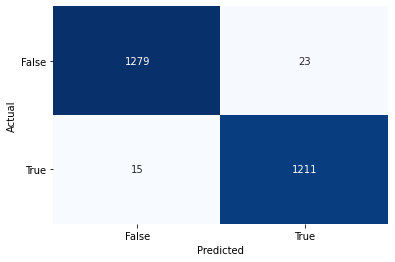

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
heatmap = sns.heatmap(result, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=["False","True"], yticklabels=["False","True"])
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0) 
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0) 
plt.xlabel("Predicted")
plt.ylabel("Actual") 
plt.show()

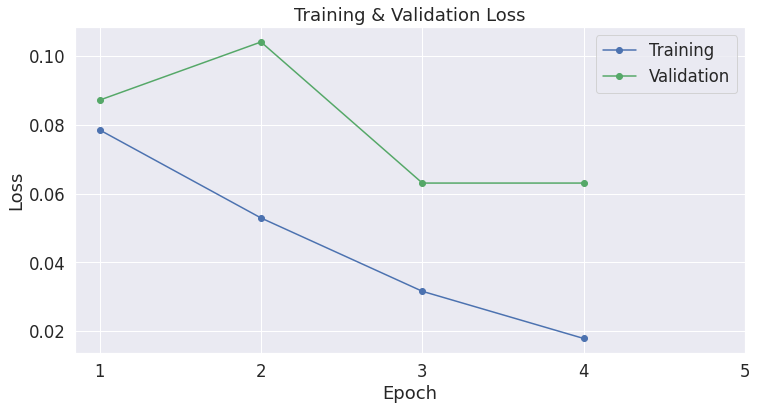

In [34]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=trainingData)
df_stats = df_stats.set_index('epoch')
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['TrainingLoss'], 'b-o', label="Training")
plt.plot(df_stats['ValidationLoss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

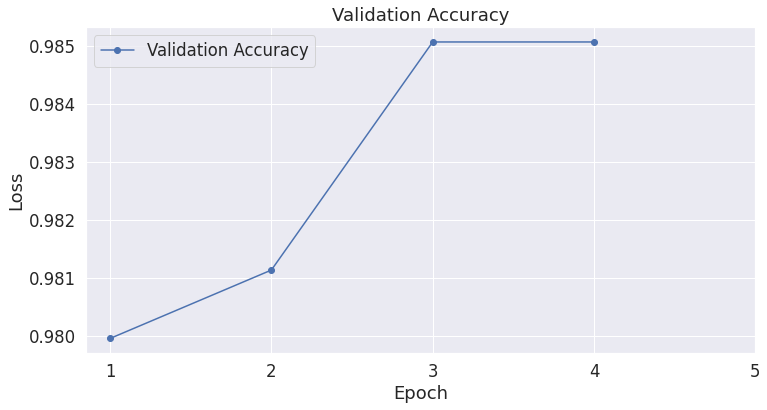

In [4]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=trainingData)
df_stats = df_stats.set_index('epoch')
%matplotlib inline
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['ValidationAccuracy'], 'b-o', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()